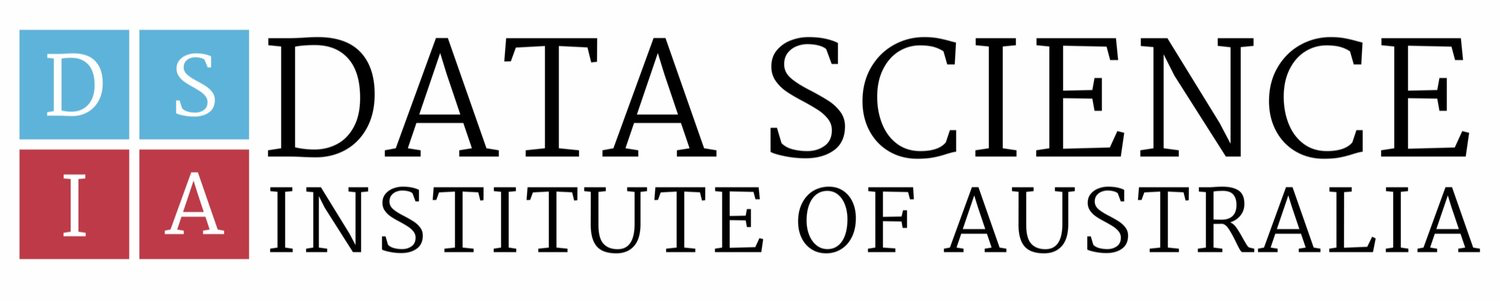

# Data Science and AI
## Lab 6.6: Principal Component Analysis

INSTRUCTIONS:

- Run the cells
- Observe and understand the results
- Answer the questions

In this Lab:
- Explore how PCA is related to correlation
- Use PCA to perform dimensionality reduction

## 1. Data
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
```shell
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC
```

Also can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

In [1]:
%matplotlib inline

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [3]:
columns = ['id', 'diagnosis']
for k in ['mean', 'std_error', 'worst']:
    for c in ['radius', 'texture', 'perimeter', 'area', 'smoothness',
              'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']:
        columns.append('%s_%s' % (c, k))

In [4]:
breast_cancer = pd.read_csv('wdbc-data.csv', names=columns, index_col='id')

## 2. EDA 
Explore dataset. Clean data. Find correlation. 

In [5]:
# Head
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
breast_cancer.shape

(569, 31)

In [7]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
diagnosis                      569 non-null object
radius_mean                    569 non-null float64
texture_mean                   569 non-null float64
perimeter_mean                 569 non-null float64
area_mean                      569 non-null float64
smoothness_mean                569 non-null float64
compactness_mean               569 non-null float64
concavity_mean                 569 non-null float64
concave_points_mean            569 non-null float64
symmetry_mean                  569 non-null float64
fractal_dimension_mean         569 non-null float64
radius_std_error               569 non-null float64
texture_std_error              569 non-null float64
perimeter_std_error            569 non-null float64
area_std_error                 569 non-null float64
smoothness_std_error           569 non-null float64
compactness_std_error          569 non-null float64
conca

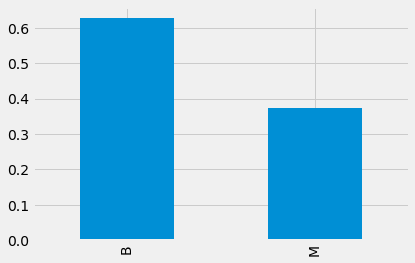

In [8]:
breast_cancer['diagnosis'].value_counts(normalize=True).plot(kind='bar')
plt.show()

## 3. Subset & Normalise
Subset the data to only include all columns except diagnosis. We will be comparing the principal components to age specifically, so we are leaving age out.

In [9]:
target_column = 'diagnosis'
feature_columns = [c for c in breast_cancer.columns if c != 'diagnosis']

In [10]:
X = breast_cancer[feature_columns]
y = breast_cancer[target_column]

In [11]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

### Calculate correlation matrix
We will be using the correlation matrix to calculate the eigenvectors and eigenvalues.

In [12]:
Xcorr = pd.DataFrame(Xs, columns=feature_columns).corr()
pd.DataFrame(Xs, columns=feature_columns).corr()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave_points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


## 4. Calculate the eigenvalues and eigenvectors from the correlation matrix

The `numpy` library has a convenient function to calculate this:
```python
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
```

In [13]:
eig_vals, eig_vecs = np.linalg.eig(Xcorr)

## 5. Calculate and plot the explained variance
A useful measure is the **explained variance**, which is calculated from the eigenvalues. 

The explained variance tells us how much information (variance) is captured by each principal component.

$$
ExpVar_i = \bigg(\frac{eigenvalue_i}{\sum\limits_j^n{eigenvalue_j}}\bigg) * 100
$$

In [14]:
def calculate_cum_var_exp(eig_vals):
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    return cum_var_exp

In [15]:
def plot_var_exp(eig_vals):
    
    cum_var_exp = calculate_cum_var_exp(eig_vals)
    
    plt.figure(figsize=(9,7))

    component_number = [i+1 for i in range(len(cum_var_exp))]

    plt.plot(component_number, cum_var_exp, lw=7)

    plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
    plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')

    ax = plt.gca()
    ax.set_xlim([1,30])
    ax.set_ylim([-5,105])

    ax.set_ylabel('cumulative variance explained', fontsize=16)
    ax.set_xlabel('component', fontsize=16)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    ax.set_title('component vs cumulative variance explained\n', fontsize=20)

    plt.show()

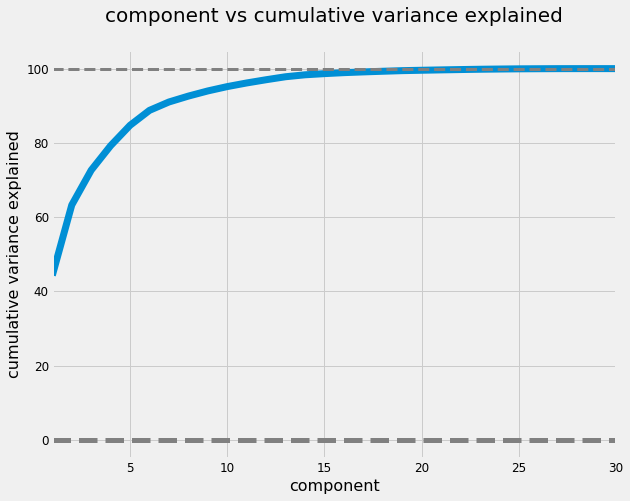

In [16]:
plot_var_exp(eig_vals)

## 6. Using sklearn For PCA
```python
from sklearn.decomposition import PCA
```

- Create an instance of PCA
- Fit X
- Plot the explained variance
- Define n_components
    - n_component
- Apply dimensionality reduction to X
    - transform
- Create PairPlot of PCA

In [17]:
breast_pca = PCA(n_components=16)
breast_pca.fit(Xs)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

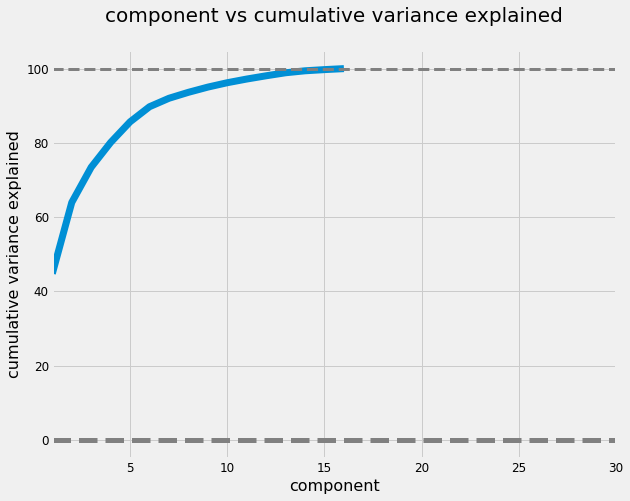

In [18]:
plot_var_exp(breast_pca.explained_variance_)

In [19]:
std_x_pca = breast_pca.transform(Xs)

In [20]:
pd.DataFrame(std_x_pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,0.262955,-0.859014,0.103388,-0.690804,-0.601793,0.745116
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,0.813120,0.157923,-0.943529,-0.653475,0.008975,-0.648809
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,-0.605604,0.124387,-0.410627,0.016680,0.483420,0.325111
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,-1.151514,1.011316,-0.933271,-0.487417,-0.168848,0.051370
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,0.651360,-0.110515,0.387948,-0.539181,0.310319,-0.152606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,-0.035471,0.987929,0.256989,-0.062651,0.123342,-0.051723,-0.404290,0.652750,0.147642
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,-1.113360,-0.105207,-0.108632,0.244804,0.222753,-0.192637,0.015555,-0.069975,-0.138184
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0.341887,0.393917,0.520877,-0.840512,0.096473,0.157418,0.285691,0.090998,-0.232648
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,-0.280239,-0.542035,-0.089296,-0.178628,-0.697461,1.225195,0.218698,0.229591,-0.061047


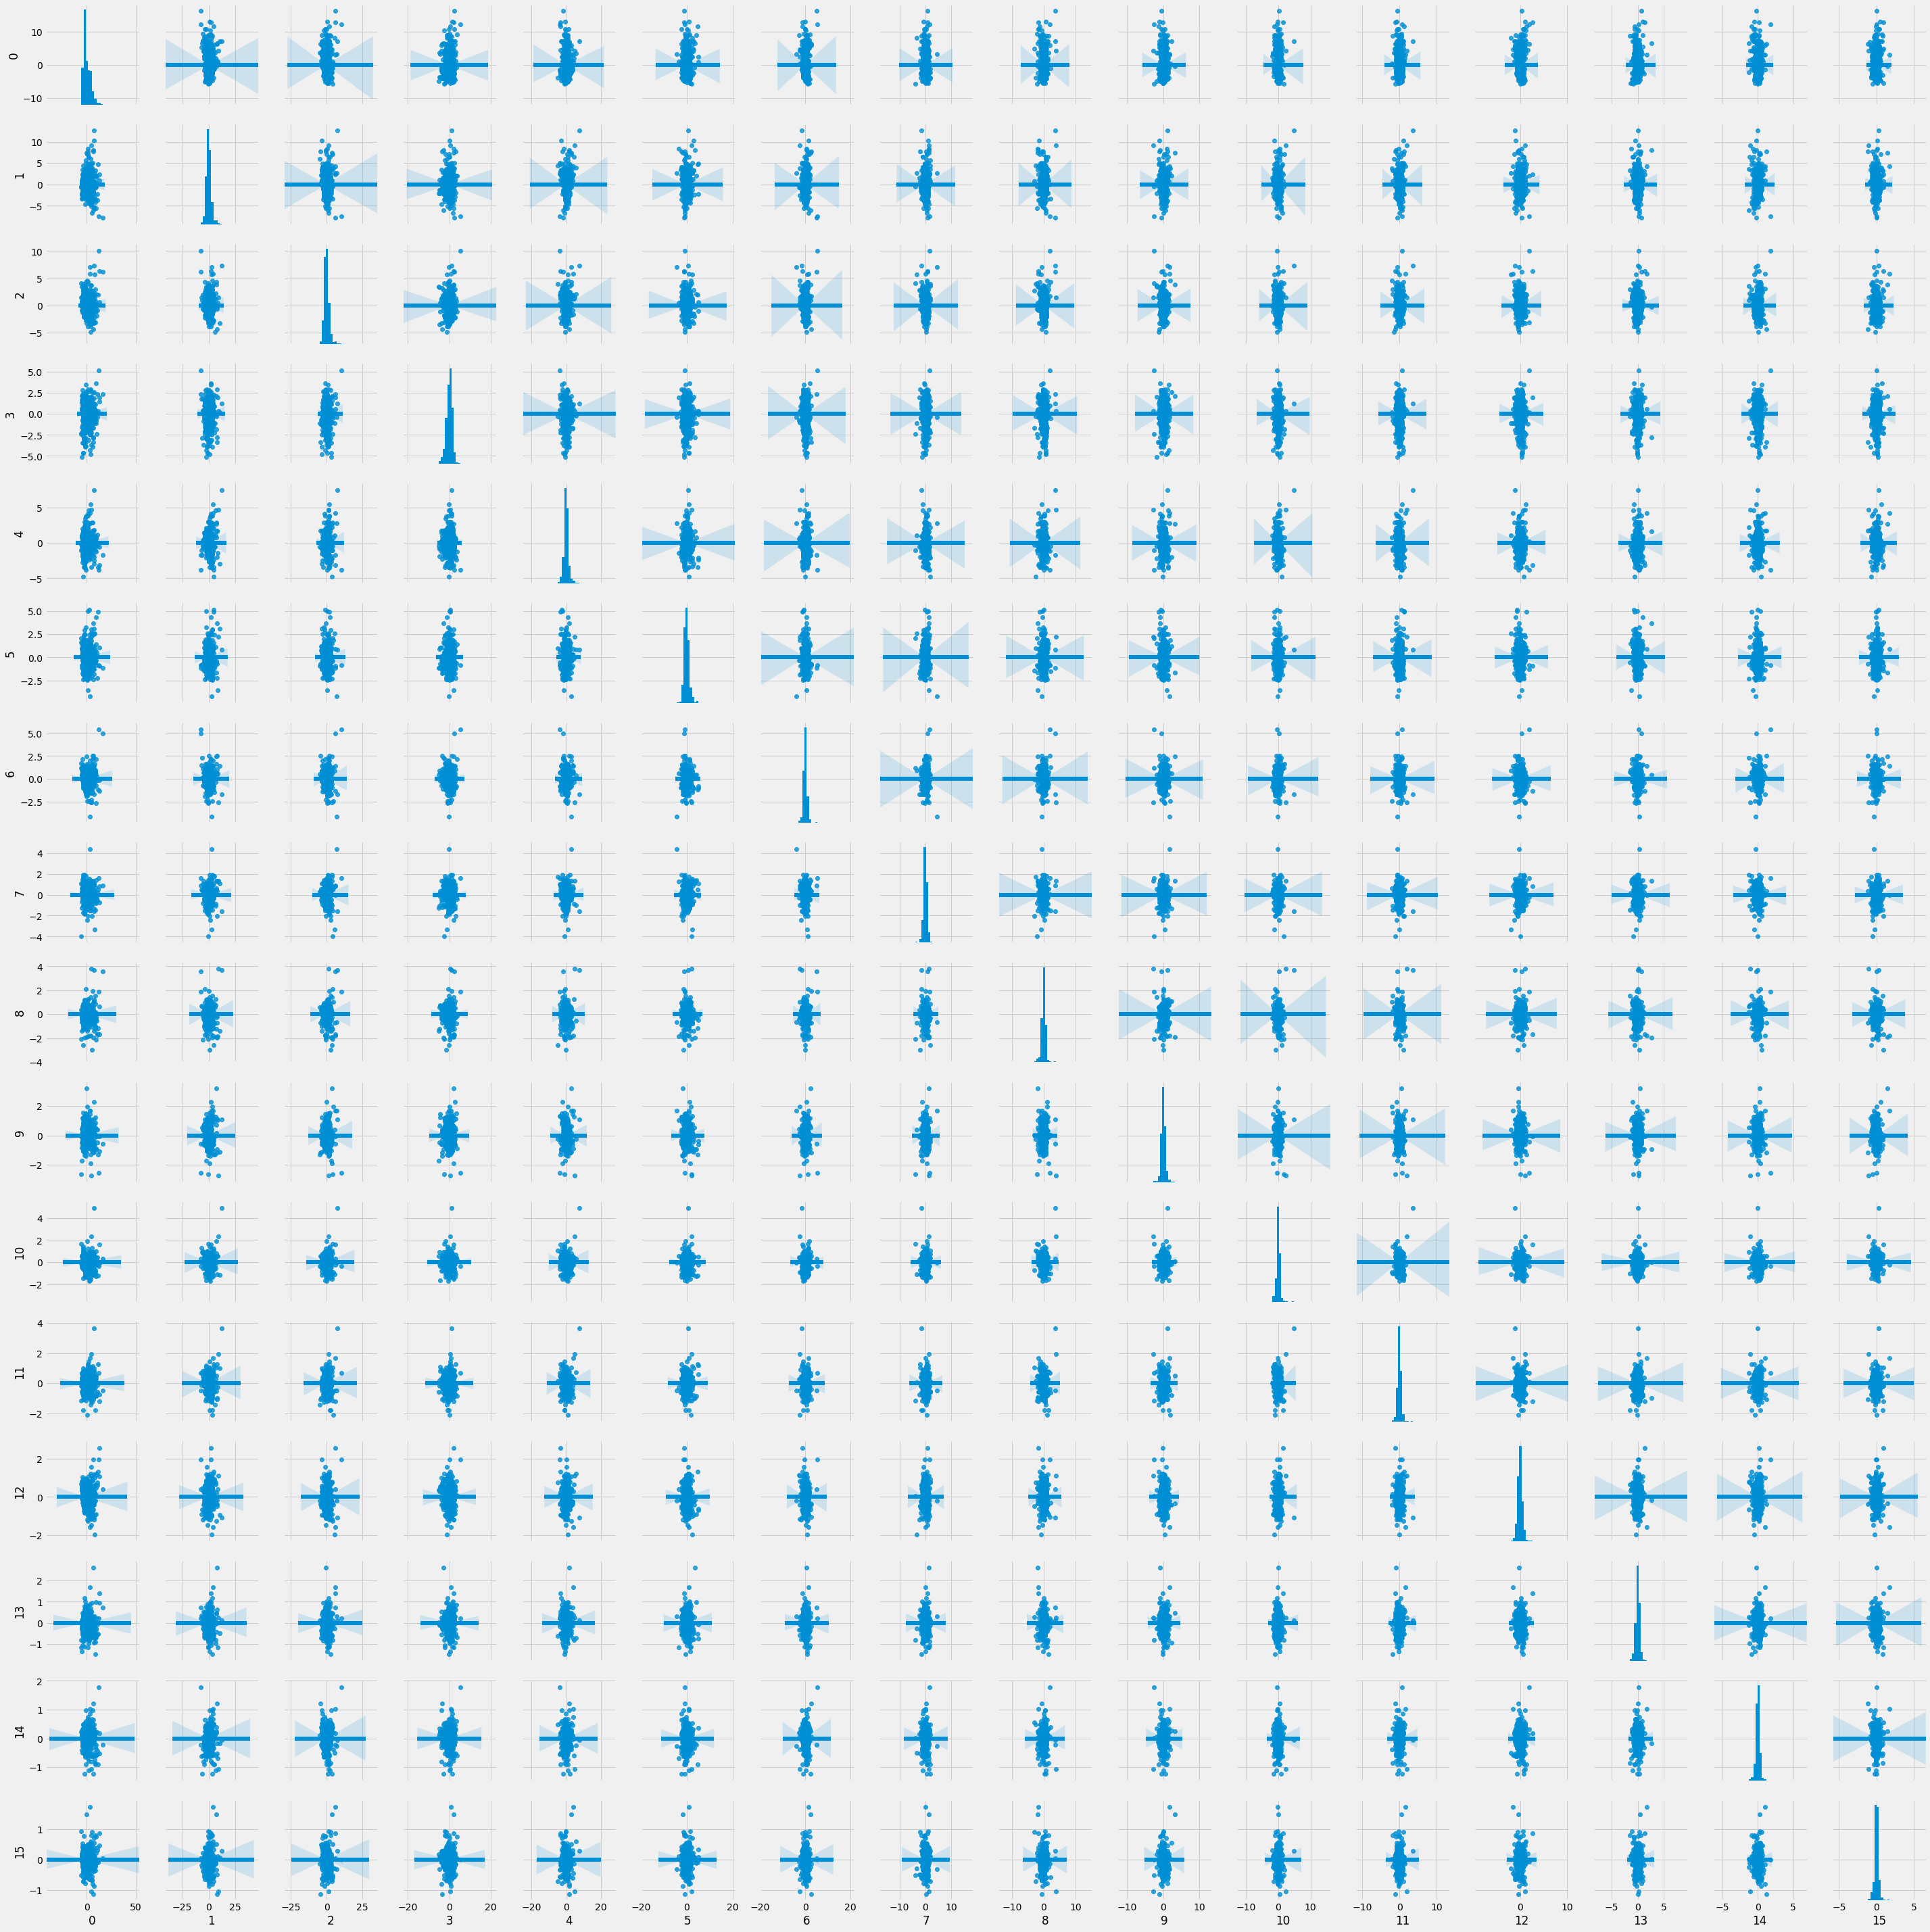

In [21]:
sns.pairplot(pd.DataFrame(std_x_pca), kind='reg')
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(std_x_pca, y, test_size=0.33, random_state=42)

In [23]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform')
scores = cross_val_score(knn5, X_train, y_train, cv=5)
print(scores.mean())

0.9579630895420369


In [24]:
knn5 = KNeighborsClassifier(n_neighbors=1, weights='uniform')
scores = cross_val_score(knn5, X_train, y_train, cv=5)
print(scores.mean())

0.9474709501025289


**References**
- [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)
- [Breast Cancer Machine Learning Prediction](https://gtraskas.github.io/post/breast_cancer/)
- [Understanding PCA (Principal Component Analysis) with Python](https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21)